# PCA on High-Level Dimensions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import analysis_utils as au
import altair as alt
import plot

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

In [3]:
try:
    df_raw = pd.read_csv('./data/super_experiment_design_space.csv')
    print(f"Successfully loaded raw dataset. Shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: './data/super_experiment_design_space.csv' not found.")

df_pca_features, numerical_cols, categorical_cols, df_processed, preprocessor = au.preprocess(df_raw, merge_conflict_dimensions=True)
print("\nPreprocessing complete.")
display(df_pca_features.head())
assert df_pca_features[df_pca_features.isnull().any(axis=1)].size == 0

Successfully loaded raw dataset. Shape: (393, 26)

Preprocessing complete.


,Task 2 Response Probability,Inter-task SOA,Distractor SOA,Task 1 CSI,Task 2 CSI,RSI,Switch Rate,Task 1 Difficulty,Task 2 Difficulty,Inter-task SOA is NA,Distractor SOA is NA,Task 2 CSI is NA,Task 2 Difficulty is NA,Response Set Overlap Mapped,RSI is Predictable,Task 1 Stimulus-Response Mapping Mapped,Task 1 Cue Type Mapped,Task 2 Stimulus-Response Mapping Mapped,Task 2 Cue Type Mapped,Trial Transition Type Mapped,Intra-Trial Task Relationship Mapped,SBC_Mapped
0,1,1875.0,0.0,0,0.0,1000.0,0.0,0.0,0.000000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
1,1,3750.0,0.0,0,0.0,1000.0,0.0,0.5,0.500000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
2,1,6200.0,0.0,0,0.0,1000.0,0.0,0.5,0.500000,0,1,0,0,RSO_Identical,1,SRM_Arbitrary,TCT_Implicit,SRM2_Arbitrary,TCT2_Implicit,TTT_Pure,ITTR_Same,N/A
3,0,150.0,0.0,0,0.0,1000.0,0.0,0.0,0.369963,1,1,1,1,RSO_NA,1,SRM_Compatible,TCT_Implicit,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA,N/A
4,0,150.0,0.0,0,0.0,1000.0,0.0,0.0,0.369963,1,0,1,1,RSO_NA,1,SRM_Compatible,TCT_Implicit,SRM2_NA,TCT2_NA,TTT_Pure,ITTR_NA,Incongruent


### Exploratory Data Analysis

In [4]:
# List of the original categorical columns we want to inspect
categorical_columns_to_explore = [
    'Response Set Overlap',
    #'Stimulus-Stimulus Congruency',
    #'Stimulus-Response Congruency',
    'Stimulus Bivalence & Congruency',
    'Task 1 Stimulus-Response Mapping',
    'Task 1 Cue Type',
    'Task 2 Stimulus-Response Mapping',
    'Task 2 Cue Type'
]
numeric_columns_to_explore = [
    'Inter-task SOA',
    'Distractor SOA',
    'Task 1 CSI',
    'Task 2 CSI', 
    'Task 2 Difficulty'
]

# Loop through the columns and print their value counts
for col in categorical_columns_to_explore:
    print(f"\nValue counts for column: '{col}'")
    # Use dropna=False to explicitly see the count of any missing values (NaNs)
    print(df_processed[col].value_counts(dropna=False))
    print("-" * 30)

print("-" * 60)
print("Review the counts above. If a sub-category has very few examples (e.g., < 5-10),")
print("it is generally better to collapse it into a broader category for the PCA.")
print("This analysis should guide the modifications to the mapping functions in Stage 3.")

for col in numeric_columns_to_explore:
    print(col, au.check_skewness(df_processed[col]))

print("-" * 60)
print("Review the skewness of the numeric columns. If they are skewed it'll be better to")
print("impute with the median instead of the mean.")


Value counts for column: 'Response Set Overlap'
Response Set Overlap
Identical                              134
NaN                                    118
Disjoint - Effector                     71
Disjoint - Modality                     32
Disjoint - Category (Same Modality)     23
Disjoint - Modality (Standard)           8
Disjoint - Modality (Non-Standard)       7
Name: count, dtype: int64
------------------------------

Value counts for column: 'Stimulus Bivalence & Congruency'
Stimulus Bivalence & Congruency
Incongruent    121
Neutral        108
N/A             82
Congruent       82
Name: count, dtype: int64
------------------------------

Value counts for column: 'Task 1 Stimulus-Response Mapping'
Task 1 Stimulus-Response Mapping
Arbitrary       215
Compatible      174
Incompatible      4
Name: count, dtype: int64
------------------------------

Value counts for column: 'Task 1 Cue Type'
Task 1 Cue Type
None/Implicit    287
Arbitrary        106
Name: count, dtype: int64
--------

## PCA Fitting

In [5]:
pipeline = au.create_pca_pipeline(numerical_cols, categorical_cols)
pipeline.fit(df_pca_features)
pca_results = pipeline.transform(df_pca_features)
column_names = [f'PC{i+1}' for i in range(pca_results.shape[1])]

# 5. Create a Pandas DataFrame with the specified column names
pca_df = pd.DataFrame(pca_results, columns=column_names)
print("PCA pipeline fitted successfully.")

PCA pipeline fitted successfully.



--- Explained Variance ---
PC1: Explained Variance = 0.207, Cumulative Variance = 0.207
PC2: Explained Variance = 0.162, Cumulative Variance = 0.369
PC3: Explained Variance = 0.116, Cumulative Variance = 0.485
PC4: Explained Variance = 0.091, Cumulative Variance = 0.576
PC5: Explained Variance = 0.067, Cumulative Variance = 0.643
PC6: Explained Variance = 0.060, Cumulative Variance = 0.703
PC7: Explained Variance = 0.054, Cumulative Variance = 0.757
PC8: Explained Variance = 0.041, Cumulative Variance = 0.798
PC9: Explained Variance = 0.037, Cumulative Variance = 0.834
PC10: Explained Variance = 0.028, Cumulative Variance = 0.862
PC11: Explained Variance = 0.020, Cumulative Variance = 0.882
PC12: Explained Variance = 0.019, Cumulative Variance = 0.901
PC13: Explained Variance = 0.017, Cumulative Variance = 0.918
PC14: Explained Variance = 0.015, Cumulative Variance = 0.933
PC15: Explained Variance = 0.014, Cumulative Variance = 0.947

--- Principal Component Loadings ---


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45
Task 2 Response Probability,0.163,-0.433,0.356,-0.118,0.173,-0.037,-0.369,-0.090,-0.084,0.095,-0.137,0.122,-0.095,0.031,-0.119,-0.064,-0.197,0.239,0.057,0.157,-0.095,0.086,-0.368,0.046,-0.008,0.099,-0.111,0.209,-0.171,-0.135,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000
Inter-task SOA,0.063,-0.199,0.208,-0.223,0.378,-0.443,0.677,0.181,0.038,0.071,0.012,-0.037,-0.027,-0.014,0.013,0.043,0.073,-0.023,0.068,0.015,0.077,0.060,-0.009,0.030,-0.001,0.023,0.000,0.002,-0.004,-0.002,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000
Distractor SOA,0.016,0.085,-0.246,0.213,0.780,0.253,0.003,-0.337,-0.232,0.003,0.188,0.040,0.014,-0.034,0.041,-0.033,0.019,-0.023,-0.040,-0.020,-0.012,0.036,-0.016,-0.020,-0.001,-0.004,-0.005,0.015,-0.003,-0.003,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000
Task 1 CSI,0.067,0.443,0.445,-0.066,0.007,-0.083,-0.055,-0.141,0.009,-0.138,0.238,0.139,-0.263,0.004,-0.268,-0.430,0.253,-0.000,0.153,-0.228,-0.030,0.061,-0.004,0.004,-0.026,-0.038,0.010,-0.005,0.022,0.006,-0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000
Task 2 CSI,0.151,0.442,0.377,0.074,-0.017,-0.226,-0.044,-0.243,-0.071,-0.016,0.095,0.090,0.127,-0.042,0.211,0.556,-0.183,0.039,-0.185,0.209,0.068,-0.073,0.003,0.038,0.021,0.034,-0.009,0.008,-0.033,-0.020,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000
RSI,-0.115,0.145,0.373,-0.242,0.082,0.630,0.122,0.434,-0.307,0.017,-0.016,-0.184,0.052,0.024,0.009,0.062,-0.009,-0.006,-0.038,0.136,-0.029,-0.053,0.007,0.014,-0.013,0.021,-0.004,-0.015,-0.003,0.005,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,-0.000,0.000
Switch Rate,0.412,0.135,-0.096,-0.001,-0.107,0.330,0.304,-0.105,0.349,0.468,0.041,0.138,-0.184,-0.057,-0.150,-0.034,-0.245,0.134,-0.001,0.115,0.024,0.004,-0.116,-0.201,-0.010,-0.039,0.020,-0.043,0.076,0.042,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,-0.000
Task 1 Difficulty,-0.199,-0.200,0.274,0.415,-0.271,0.050,0.313,-0.428,-0.308,0.281,-0.100,-0.237,0.100,0.042,-0.105,-0.119,0.087,0.003,-0.121,-0.033,-0.099,0.036,0.043,0.014,0.032,-0.004,-0.010,0.020,-0.005,0.006,0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000
Task 2 Difficulty,-0.095,-0.195,0.215,0.647,0.019,0.103,0.111,0.324,0.213,-0.292,0.270,0.228,-0.118,-0.043,0.032,0.006,-0.270,0.027,0.030,-0.048,0.069,-0.049,-0.002,0.034,-0.011,0.004,-0.004,-0.023,-0.036,-0.024,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000
Inter-task SOA is NA_0,0.067,-0.170,0.149,-0.062,0.068,0.022,-0.103,-0.059,0.017,0.006,-0.060,0.117,-0.014,-0.016,0.047,-0.035,-0.014,0.071,-0.001,0.071,0.012,0.016,0.563,-0.246,0.008,-0.055,-0.011,-0.076,0.042,0.028,0.006,-0.049,-0.014,-0.068,0.044,0.061,0.014,-0.267,-0.239,-0.030,0.287,0.000,0.423,0.131,-0.280


Sparseness of top 3 loadings: 0.34911298632717297


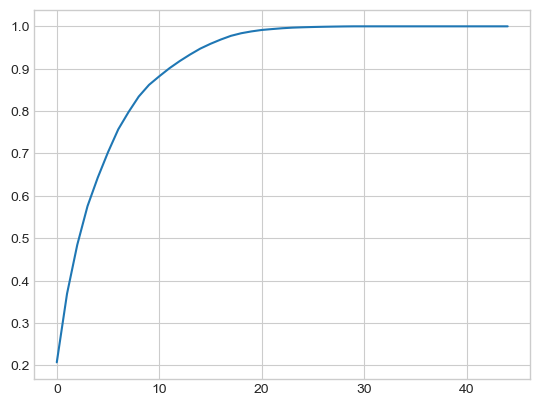

In [32]:
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\n--- Explained Variance ---")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
    if cum_var > 0.95: break
    print(f"PC{i+1}: Explained Variance = {var:.3f}, Cumulative Variance = {cum_var:.3f}")

plt.plot(range(len(cumulative_variance)), cumulative_variance)
with open("cumulative_variance.tsv", 'w') as cumulative_variance_file:
    cumulative_variance_file.write("PC\tcum_var\n")
    cumulative_variance_file.write("0\t0\n")
    [cumulative_variance_file.write(f"{i+1}\t{cum_var*100}\n") for i, cum_var in enumerate(cumulative_variance) if cum_var < 0.9995]
    
loadings = au.get_component_loadings(pipeline, numerical_cols, categorical_cols)
print("\n--- Principal Component Loadings ---")
display(loadings.round(3))
print("Sparseness of top 3 loadings:", np.mean(au.get_loadings_sparseness(loadings.to_numpy()[:,:3])))

### Top weights for the first four components

In [7]:
display(loadings["PC1"].sort_values(key=abs, ascending=False).round(3)[:16])

Switch Rate                                               0.412
Task 2 Cue Type Mapped_TCT2_NA                           -0.245
Task 2 Stimulus-Response Mapping Mapped_SRM2_NA          -0.245
Task 2 Difficulty is NA_1                                -0.245
Task 2 Difficulty is NA_0                                 0.245
Task 2 CSI is NA_0                                        0.244
Task 2 CSI is NA_1                                       -0.244
Response Set Overlap Mapped_RSO_NA                       -0.242
Intra-Trial Task Relationship Mapped_ITTR_NA             -0.238
Trial Transition Type Mapped_TTT_Pure                    -0.225
Intra-Trial Task Relationship Mapped_ITTR_Different       0.219
Task 1 Difficulty                                        -0.199
Task 2 Stimulus-Response Mapping Mapped_SRM2_Arbitrary    0.179
Task 2 Cue Type Mapped_TCT2_Implicit                      0.177
Task 2 Response Probability                               0.163
Task 2 CSI                              

In [8]:
display(loadings["PC2"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 1 CSI                                  0.443
Task 2 CSI                                  0.442
Task 2 Response Probability                -0.433
Task 1 Difficulty                          -0.200
Inter-task SOA                             -0.199
Task 2 Difficulty                          -0.195
Task 2 Cue Type Mapped_TCT2_Implicit       -0.178
Inter-task SOA is NA_1                      0.170
Inter-task SOA is NA_0                     -0.170
RSI                                         0.145
Task 1 Cue Type Mapped_TCT_Implicit        -0.142
Task 1 Cue Type Mapped_TCT_Arbitrary        0.142
Switch Rate                                 0.135
Task 2 Cue Type Mapped_TCT2_Arbitrary       0.133
Response Set Overlap Mapped_RSO_Disjoint   -0.131
Trial Transition Type Mapped_TTT_Pure      -0.103
Name: PC2, dtype: float64

In [9]:
display(loadings["PC3"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 1 CSI                                   0.445
Task 2 CSI                                   0.377
RSI                                          0.373
Task 2 Response Probability                  0.356
Task 1 Difficulty                            0.274
Distractor SOA                              -0.246
Task 2 Difficulty                            0.215
Inter-task SOA                               0.208
Inter-task SOA is NA_0                       0.149
Inter-task SOA is NA_1                      -0.149
Distractor SOA is NA_0                      -0.131
Distractor SOA is NA_1                       0.131
Response Set Overlap Mapped_RSO_Disjoint     0.115
Trial Transition Type Mapped_TTT_Pure        0.106
SBC_Mapped_Neutral                          -0.103
Response Set Overlap Mapped_RSO_Identical   -0.103
Name: PC3, dtype: float64

In [10]:
display(loadings["PC4"].sort_values(key=abs, ascending=False).round(3)[:16])

Task 2 Difficulty                                          0.647
Task 1 Difficulty                                          0.415
RSI                                                       -0.242
Inter-task SOA                                            -0.223
Distractor SOA                                             0.213
Task 1 Stimulus-Response Mapping Mapped_SRM_Compatible     0.179
Task 1 Stimulus-Response Mapping Mapped_SRM_Arbitrary     -0.169
Distractor SOA is NA_1                                    -0.134
Distractor SOA is NA_0                                     0.134
Task 2 Cue Type Mapped_TCT2_Arbitrary                      0.131
Task 1 Cue Type Mapped_TCT_Arbitrary                       0.121
Task 1 Cue Type Mapped_TCT_Implicit                       -0.121
Intra-Trial Task Relationship Mapped_ITTR_Different        0.121
Task 2 Response Probability                               -0.118
Task 2 Stimulus-Response Mapping Mapped_SRM2_Compatible    0.080
Task 2 CSI               

### Find Centroids of Paradigms and Interpolate Them

### Plot Experimental Conditions

In [33]:
# --- 5. Define Tooltip Columns ---
tooltip_cols = [
    alt.Tooltip('Experiment:N', title='Experiment'),
    alt.Tooltip('Paradigm:N', title='Paradigm Class'),
    alt.Tooltip('Task 2 Response Probability:Q', title='T2 Response Probability', format='.2f'),
    alt.Tooltip('Inter-task SOA:N', title='Inter-task SOA'),
    alt.Tooltip('Distractor SOA:N', title='Distractor SOA'),
    alt.Tooltip('Task 1 CSI:Q', title='T1 CSI', format='.0f'),
    alt.Tooltip('Task 2 CSI:Q', title='T2 CSI', format='.0f'),
    alt.Tooltip('RSI:Q', title='RSI', format='.0f'),
    alt.Tooltip('RSI is Predictable:N', title='RSI Predictable'),
    alt.Tooltip('Switch Rate:Q', title='Switch Rate (%)', format='.1f'),
    alt.Tooltip('Trial Transition Type:N', title='Transition Type'),
    alt.Tooltip('Stimulus Bivalence & Congruency:N', title='Stimulus Bivalence & Congruency'),
    alt.Tooltip('Response Set Overlap:N', title='Response Set Overlap'),
    alt.Tooltip('Task 1 Stimulus-Response Mapping:N', title='T1 Stimulus-Response Mapping'),
    alt.Tooltip('Task 2 Stimulus-Response Mapping:N', title='T2 Stimulus-Response Mapping'),
    alt.Tooltip('Task 1 Difficulty:Q', title='T1 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 Difficulty:Q', title='T2 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 CSI is NA:N', title='T2 CSI is N/A'),
    alt.Tooltip('Task 2 Difficulty is NA:N', title='T2 Difficulty is N/A'),
    alt.Tooltip('Inter-task SOA is NA:N', title='Inter-task SOA is N/A'),
    alt.Tooltip('Distractor SOA is NA:N', title='Distractor SOA is N/A')
]
# --- 1. Combine data and calculate centroids ---
plot_df = pd.concat([
    df_processed.reset_index(drop=True),
    pca_df.reset_index(drop=True)
], axis=1)
plot_df['Point Type'] = 'Empirical Data'

centroids_df = au.find_centroids(plot_df[[c for c in plot_df.columns if c.startswith("PC")] + ["Paradigm"]], paradigm_col='Paradigm')
centroids_df = pd.DataFrame.from_dict(centroids_df, orient='index').reset_index()
centroids_df = centroids_df.rename(columns={'index': 'Paradigm'})
centroids_df['Point Type'] = 'Centroid'

# --- 2. Generate interpolated points using the new utility function ---
interpolation_pairs = [
    ('Dual-Task_PRP', 'Task Switching'),
    ('Dual-Task_PRP', 'Interference'),
    ('Task Switching', 'Interference')
]

model_artifacts_pca = {'type': 'pca', 'pipeline': pipeline}

interpolated_df = au.generate_interpolated_points(
    latent_space_df=plot_df,
    model_artifacts=model_artifacts_pca,
    interpolation_pairs=interpolation_pairs
)

# --- 3. Combine all dataframes for plotting ---
final_plot_df = pd.concat([plot_df, centroids_df, interpolated_df], ignore_index=True)
final_plot_df['Parent1'] = final_plot_df['Parent1'].fillna('N/A')
final_plot_df['Parent2'] = final_plot_df['Parent2'].fillna('N/A')
final_plot_df = plot.add_na_mask_from_flag(final_plot_df)

# Now, call the plotting function from plot.py
# (Assuming you have also moved the plotting logic there)
pca_chart = plot.create_latent_space_plot(final_plot_df, "PC1", "PC2", "PC1 (Procedural Stability <-> Dynamic Coordination)",
                                          "PC2 (Proactive Preparation vs. Reactive Dual-Task Coordination)",
                                          "Cognitive Control Experimental Conditions", tooltip_cols,
                                          has_interpolation=True, output_filename="pca_plot.pdf")
pca_chart

alt.LayerChart(...)

#### Sparseness Measure of first four PCs (to match MOFA+'s number of factors)

In [12]:
np.mean(au.get_loadings_sparseness(loadings[["PC1", "PC2", "PC3", "PC4"]].to_numpy()))

np.float64(0.3622721636962258)

#### Paradigm Separation Validation

In [38]:
au.validate_paradigm_separation(plot_df, ["PC1", "PC2"], target_col='Paradigm')

{'accuracy': 0.9411764705882353,
 'classification_report': {'Dual-Task_PRP': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 4.0},
  'Interference': {'precision': 1.0,
   'recall': 0.75,
   'f1-score': 0.8571428571428571,
   'support': 4.0},
  'Single-Task': {'precision': 0.5,
   'recall': 1.0,
   'f1-score': 0.6666666666666666,
   'support': 1.0},
  'Task Switching': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 8.0},
  'accuracy': 0.9411764705882353,
  'macro avg': {'precision': 0.875,
   'recall': 0.9375,
   'f1-score': 0.8809523809523809,
   'support': 17.0},
  'weighted avg': {'precision': 0.9705882352941176,
   'recall': 0.9411764705882353,
   'f1-score': 0.9467787114845938,
   'support': 17.0}},
 'confusion_matrix': array([[4, 0, 0, 0],
        [0, 3, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 8]]),
 'model_name': 'KNeighborsClassifier(n_neighbors=3)',
 'feature_names': ['PC1', 'PC2'],
 'class_names': ['Dual-Task_PRP',
  'Inter